<h1><center>One Way Anova</center></h1>

### Data

In [1]:
data("PlantGrowth")
?PlantGrowth
head(PlantGrowth)

weight,group
4.17,ctrl
5.58,ctrl
5.18,ctrl
6.11,ctrl
4.50,ctrl
4.61,ctrl


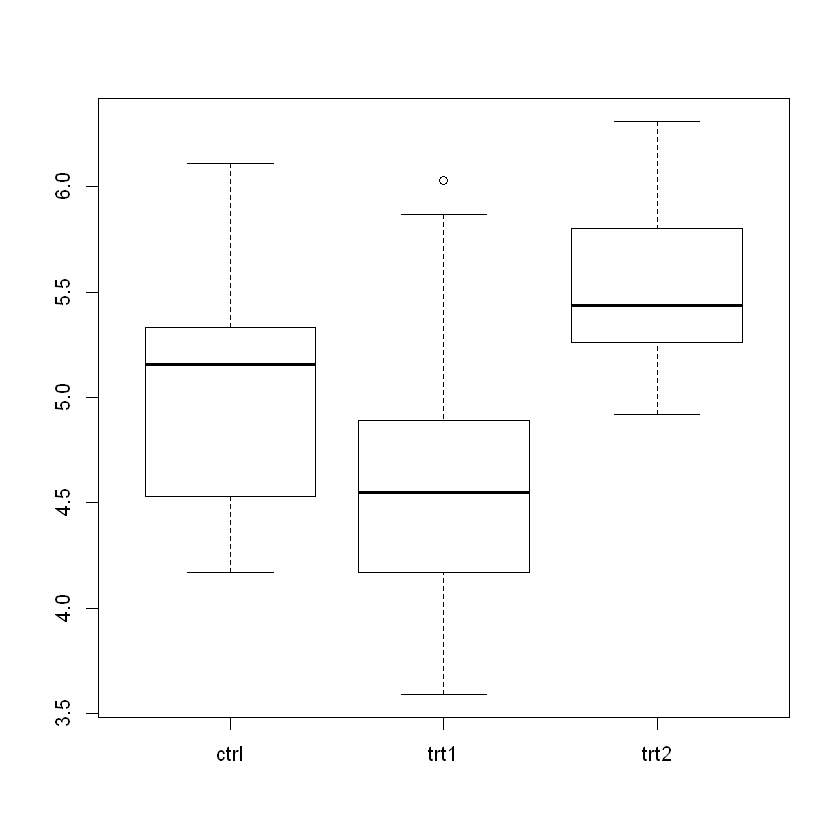

In [2]:
# Because the explanatory variable group is a factor and not continuous, we choose to visualize the data
# with box plots rather than scatter plots.

boxplot(weight ~ group, data=PlantGrowth)

# The box plots summarize the distribution of the data for each of the three groups. 
# It appears that treatment 2 has the highest mean yield. It might be questionable whether each group has
# the same variance, but we’ll assume that is the case and in future we'll relax this assumption also.

### Modelling Using R

In [3]:
lmod = lm(weight ~ group, data=PlantGrowth)

summary(lmod)
# The summary that we are getting here is wrt to Additive model because R uses this model rather than th Cell Mean Model.
# Hence, the “intercept” in this model is the mean yield for the control group. The two other parameters are the estimated 
# effects of treatments 1 and 2. To recover the mean yield in treatment group 1, we've to add the intercept term and the
# treatment 1 effect.


Call:
lm(formula = weight ~ group, data = PlantGrowth)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0710 -0.4180 -0.0060  0.2627  1.3690 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.0320     0.1971  25.527   <2e-16 ***
grouptrt1    -0.3710     0.2788  -1.331   0.1944    
grouptrt2     0.4940     0.2788   1.772   0.0877 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6234 on 27 degrees of freedom
Multiple R-squared:  0.2641,	Adjusted R-squared:  0.2096 
F-statistic: 4.846 on 2 and 27 DF,  p-value: 0.01591


In [4]:
anova(lmod)

# The anova() function in R compares variability of observations between the treatment groups to variability
# within the treatment groups to test whether all means are equal or whether at least one is different. The small
# p-value here suggests that the means are not all equal or we can say variability within the groups is high.

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
group,2,3.76634,1.8831700,4.846088,0.01590996
Residuals,27,10.49209,0.3885959,NA,NA


## Bayesian Modelling [Assuming Similar Variance for each Group]

In [5]:
library("coda")
library("rjags")

Warning message:
"package 'coda' was built under R version 3.4.4"Warning message:
"package 'rjags' was built under R version 3.4.4"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [6]:
set.seed(82)

In [7]:
# CELL MEAN MODEL [Each group has its own mean.]
#        B1        B2        1B3
# A1   mu<1,1>   mu<1,2>   mu<1,3>
# A2   mu<2,1>   mu<2,2>   mu<2,3>
#
#
#
#
# ADDITIVE MODEL
# E(y) = mu + a2*I(ax=2) + b2*I(bx=2) + b3*I(bx=3)
#
# Here I(ax=2) is an indicator function which is 1 when input is 2 otherwise 0.

In [8]:
# Model String

mod_0_str = " model {
    # Actual Model (Cell Mean Model)
    for (i in 1:length(y)) {
        y[i] ~ dnorm(mu[grp[i]], prec)
    }
    
    # Priors
    for (j in 1:3) {
        mu[j] ~ dnorm(0.0, 1.0/1.0e6)
    }
    prec ~ dgamma(5/2.0, 5*1.0/2.0)
    
    # Variables Dependent on Priors
    sig = sqrt( 1.0 / prec )
} "

In [9]:
# Data to be fed in Model as a list.

data_jags = list(y = PlantGrowth$weight, 
                 grp = as.numeric(PlantGrowth$group))

In [10]:
# Parameters to be estimated.

params_0 = c("mu", "sig")

In [11]:
# Initialization of the model parameters

inits_0 = function() {
    inits = list("mu" = rnorm(3,0.0,100.0), 
                 "prec" = rgamma(1,1.0,1.0))
}

In [12]:
#JAGS Model

mod_0 = jags.model(textConnection(mod_0_str), 
                   data=data_jags, 
                   inits=inits_0, 
                   n.chains=3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 4
   Total graph size: 74

Initializing model



In [13]:
# Burn In

update(mod_0, 1e3)

In [14]:
# Monte Carlo Simulations

mod_0_sim = coda.samples(model = mod_0, 
                         variable.names = params_0, 
                         n.iter = 1e4)

In [15]:
# Combine the Chains along the Rows

mod_0_csim = as.mcmc(do.call(rbind, mod_0_sim))

### Model Checking

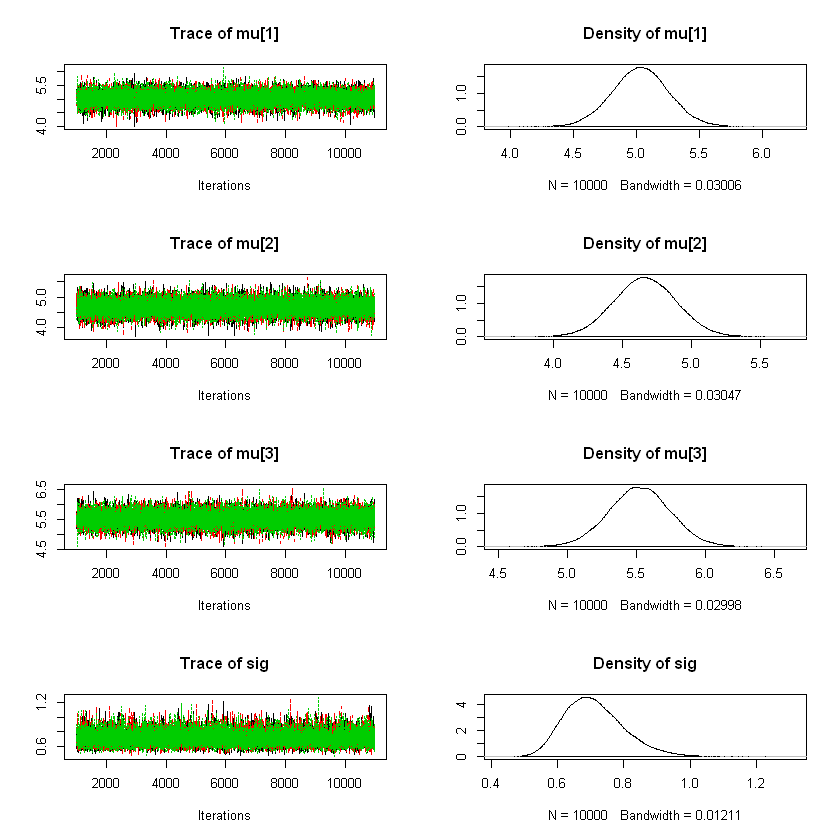

In [16]:
plot(mod_0_sim)

In [17]:
gelman.diag(mod_0_sim)

Potential scale reduction factors:

      Point est. Upper C.I.
mu[1]          1          1
mu[2]          1          1
mu[3]          1          1
sig            1          1

Multivariate psrf

1

In [18]:
autocorr.diag(mod_0_sim)

,mu[1],mu[2],mu[3],sig
Lag 0,1.0000000000,1.000000000,1.0000000000,1.000000000
Lag 1,-0.0007370524,0.006863650,0.0003830353,0.083155039
Lag 5,-0.0014796343,0.001264971,-0.0024913004,0.004934900
Lag 10,-0.0035328712,-0.007780656,-0.0060083072,0.001786973
Lag 50,-0.0079586227,-0.002372889,-0.0097544769,0.002376041


In [19]:
effectiveSize(mod_0_sim)

mu[1]    mu[2]    mu[3]      sig 
30000.00 30206.19 29270.13 25395.30

In [20]:
# All the 4 analysis done above shows that model is perfect. 
# The brief explantion of each test is given in Linear Regression Notebook in Same Repository.
# Now we have to do some analysis on Residuals.

### Residuals Checking

In [21]:
# Posterior Mean of Parameters

pm_params = colMeans(mod_0_csim)
pm_params

mu[1]     mu[2]     mu[3]       sig 
5.0337872 4.6631422 5.5247225 0.7122747

In [22]:
# Lets comapre it with the model that we fit using R.
coefficients(lmod)

# mu[1] = Intercept
# mu[2] = Intercept + grouptrt1
# mu[3] = Intercept + grouptrt2

(Intercept)   grouptrt1   grouptrt2 
      5.032      -0.371       0.494

In [23]:
yhat = pm_params[1:3][data_jags$grp]
resid = data_jags$y - yhat

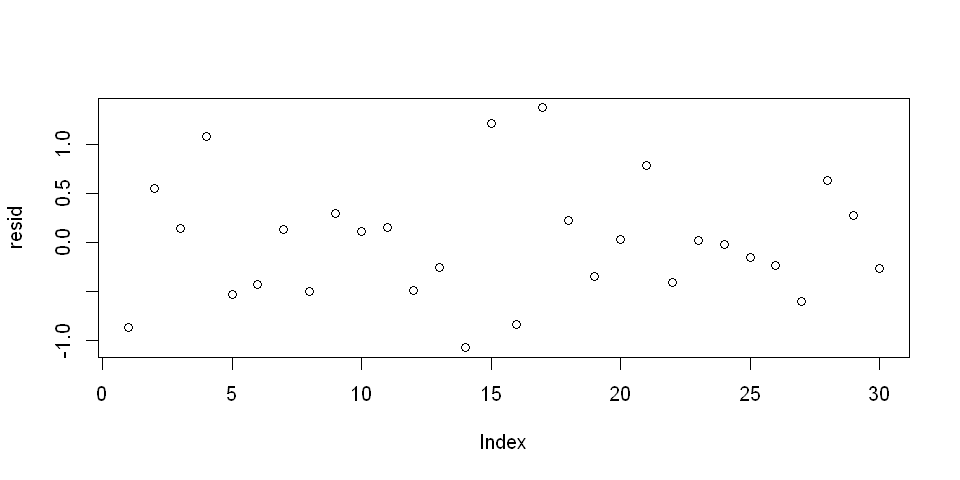

In [24]:
options(repr.plot.width=8, repr.plot.height=4)

plot(resid)
# There seems no pattern. So it's good.

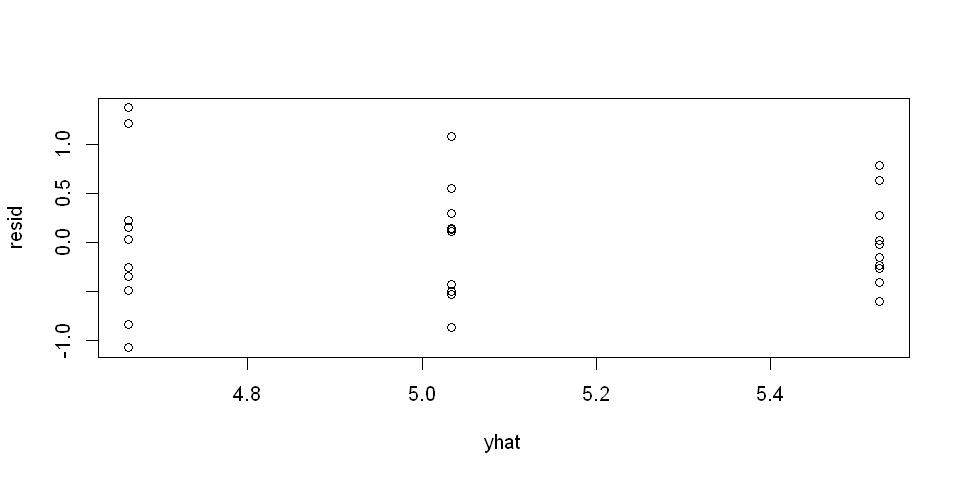

In [25]:
plot(yhat, resid)

# Here we can see the variance between all three groups are different. But above we've assumed hat variance is same.
# We can again model the situation bu his time we'll include seprate variave for each model.

### Results

In [26]:
summary(lmod)


Call:
lm(formula = weight ~ group, data = PlantGrowth)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0710 -0.4180 -0.0060  0.2627  1.3690 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.0320     0.1971  25.527   <2e-16 ***
grouptrt1    -0.3710     0.2788  -1.331   0.1944    
grouptrt2     0.4940     0.2788   1.772   0.0877 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6234 on 27 degrees of freedom
Multiple R-squared:  0.2641,	Adjusted R-squared:  0.2096 
F-statistic: 4.846 on 2 and 27 DF,  p-value: 0.01591


In [27]:
# Highest Posterior Density 95% Confidence Interval

HPDinterval(mod_0_csim, prob = 0.95)

,lower,upper
mu[1],4.5820107,5.4809597
mu[2],4.2199687,5.1087478
mu[3],5.0778967,5.9675086
sig,0.5450947,0.8949534


In [28]:
mean(mod_0_csim[,2] > mod_0_csim[,1])

# Result shows that in 12% cases treatement 1 will increase mean yield.

[1] 0.1222

In [29]:
# We are interested to know if one of the treatments increases mean yield. 
# It is clear that treatment 1 does not. What about treatment 2?

mean(mod_0_csim[,3] > mod_0_csim[,1])

# Result shows that in 94% cases treatement 2 will increase mean yield.

[1] 0.9372

In [30]:
# It may be the case that treatment 2 would be costly to put into production. 
# Suppose that to be worthwhile, this treatment must increase mean yield by 10%. 
# What is the posterior probability that the increase is at least that?

mean(mod_0_csim[,3] > 1.1*mod_0_csim[,1])

# We have about 50/50 odds that adopting treatment 2 would increase mean yield by at least 10%.

[1] 0.4888667

## Bayesian Modelling [Assuming Different Variance for each Group]

In [31]:
# Model String

mod_1_str = " model {
    # Actual Model (Cell Mean Model)
    for (i in 1:length(y)) {
        y[i] ~ dnorm(mu[grp[i]], prec[grp[i]])
    }
    
    # Priors
    for (j in 1:3) {
        mu[j] ~ dnorm(0.0, 1.0/1.0e6)
        prec[j] ~ dgamma(5/2.0, 5*1.0/2.0)
    }
    
    # Variables Dependent on Priors
    for(k in 1:3){
        sig[k] = sqrt( 1.0 / prec[k])
    }
} "

In [32]:
# Parameters to be estimated.

params_1 = c("mu", "sig")

In [33]:
# Initialization of the model parameters

inits_1 = function(){
    inits = list("mu" = rnorm(3, 0.0, 100.0), 
                 "prec" = rgamma(3, 1.0, 1.0))
}

In [34]:
#JAGS Model

mod_1 = jags.model(textConnection(mod_1_str), 
                   data = data_jags, 
                   inits = inits_1, 
                   n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 6
   Total graph size: 80

Initializing model



In [35]:
# Burn In

update(mod_1, 1e3)

In [36]:
# Monte Carlo Simulations

mod_1_sim = coda.samples(model = mod_1, 
                         variable.names = params_1, 
                         n.iter = 1e4)

In [37]:
# Combine the Chains

mod_1_csim = as.mcmc(do.call(rbind, mod_1_sim))

### Model Checking

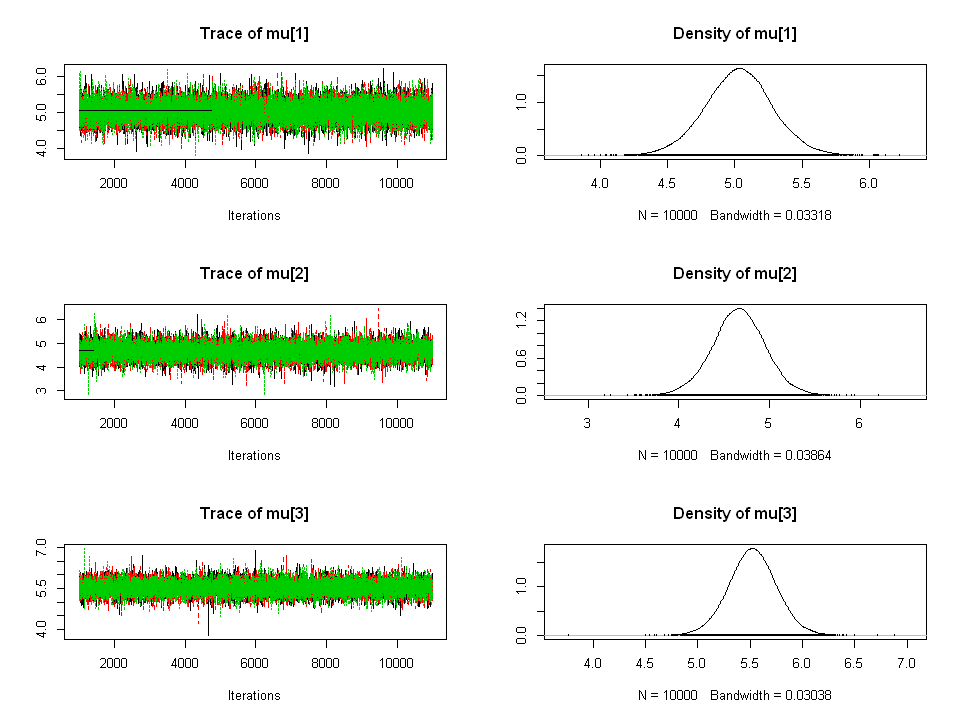

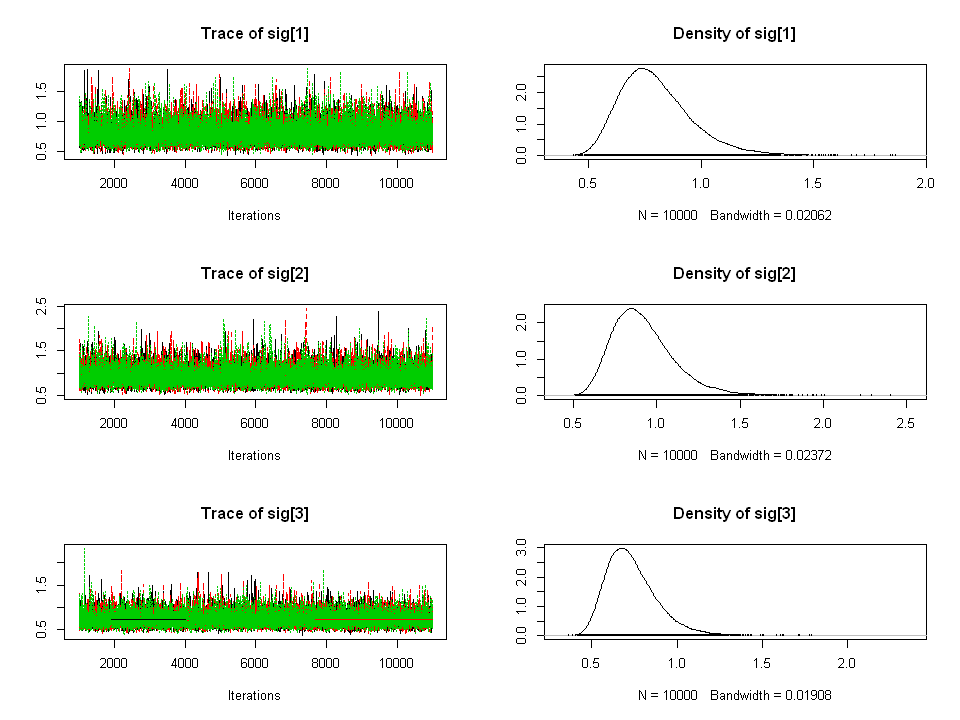

In [38]:
options(repr.plot.width=8, repr.plot.height=6)

plot(mod_1_sim)

In [39]:
gelman.diag(mod_1_sim)

Potential scale reduction factors:

       Point est. Upper C.I.
mu[1]           1          1
mu[2]           1          1
mu[3]           1          1
sig[1]          1          1
sig[2]          1          1
sig[3]          1          1

Multivariate psrf

1

In [40]:
autocorr.diag(mod_1_sim)

,mu[1],mu[2],mu[3],sig[1],sig[2],sig[3]
Lag 0,1.0000000000,1.000000000,1.000000000,1.0000000000,1.000000000,1.000000000
Lag 1,-0.0017066262,-0.014720993,0.001057329,0.0593338006,0.082712511,0.078374284
Lag 5,0.0123631233,0.003907868,0.001033481,0.0009507277,-0.000724416,-0.015881019
Lag 10,0.0023098485,-0.005952179,0.003676434,-0.0036191356,0.007344449,-0.011033490
Lag 50,-0.0002786602,-0.002535718,0.001647979,-0.0047669559,0.003023991,0.001728805


In [41]:
effectiveSize(mod_1_sim)

mu[1]    mu[2]    mu[3]   sig[1]   sig[2]   sig[3] 
29551.55 30460.04 30000.00 26032.96 25138.44 26124.15

### Residual Checking

In [42]:
# Posterior Mean of Parameters

pm_params = colMeans(mod_1_csim)
pm_params

mu[1]     mu[2]     mu[3]    sig[1]    sig[2]    sig[3] 
5.0308953 4.6631012 5.5253304 0.8036373 0.9242171 0.7356108

In [43]:
# Old Posterior Means
colMeans(mod_0_csim)

mu[1]     mu[2]     mu[3]       sig 
5.0337872 4.6631422 5.5247225 0.7122747

In [44]:
# Here we can see that the three means are not changed much, but Now we have separeate variability for each parameter.

In [45]:
yhat = pm_params[1:3][data_jags$grp]
resid = data_jags$y - yhat

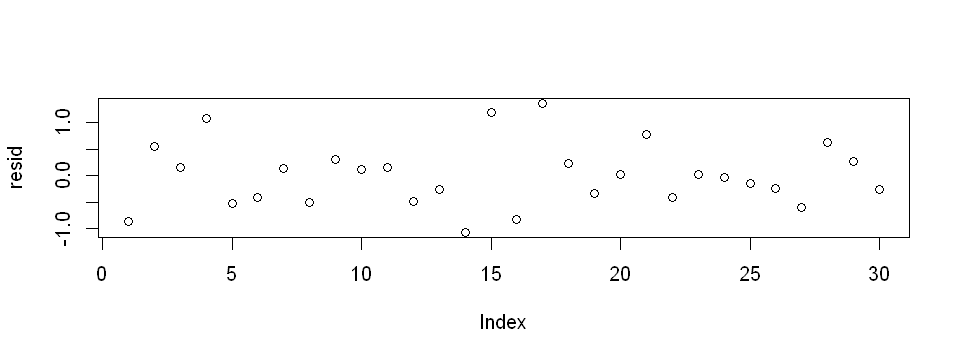

In [46]:
options(repr.plot.width=8, repr.plot.height=3)

plot(resid)

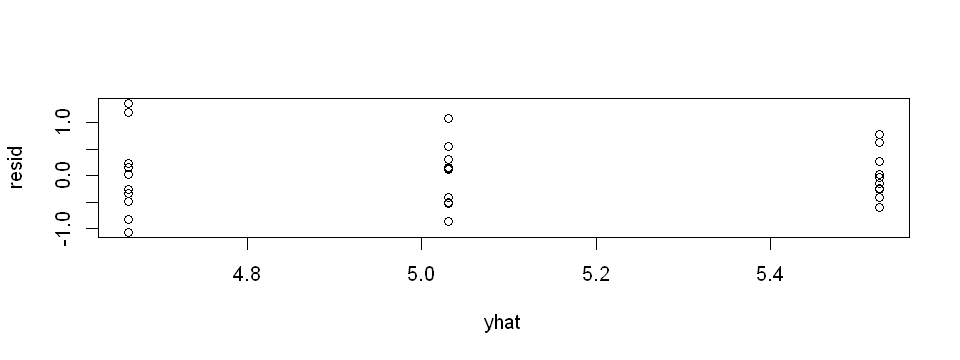

In [47]:
plot(yhat, resid)

## Model Comparision

In [49]:
dic.samples(mod_0, n.iter = 1e4)

Mean deviance:  59.04 
penalty 4.147 
Penalized deviance: 63.19 

In [50]:
dic.samples(mod_1, n.iter = 1e4)

Mean deviance:  61.25 
penalty 5.767 
Penalized deviance: 67.02 

<h1><center>Two Factor ANOVA</center></h1>